# Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus

## Textual Analysis

**Overview**:
* 1. [Removing stopwords](#Section_1)
* 2. [Semantic scoring](#Section_2)
* 3. [Love words extraction](#Section_3)
* 4. [Representing the data](#Section_4)
* 5. [Next steps](#Section_5)
    - 5.1 [Reference vector](#Section_5.1)
    - 5.2 [Threshold](#Section_5.2)

In [51]:
from load_data import *
from textual_analysis import *
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os
os.environ["OMP_NUM_THREADS"] = '5'
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# To load spacy components, put to False when loaded before
load_nltk = False

if load_nltk == True:
    #Load Natural Language Tool Kit (NLTK) word banks
    nltk.download('stopwords')
    nltk.download('punkt')

    #Load the spacy model for the semantic analysis
    nlp_spacy = spacy.load("en_core_web_lg")

download_data(coreNLP=False)
plot_df = load_plot_df()
movie_df = load_movie_df()

### 1. Removing stopwords

A stop word is a frequently used term that a search engine has been configured to ignore, both while indexing entries for searching and when retrieving them as the result of a search query. Examples of stop words include "the," "a," "an," and "in."
We don't want these terms to take up any unnecessary storage space or processing time in our database. By keeping a record of the terms you believe to be stop words, we may easily eliminate them for this reason.

In [24]:
#Take random sample of 5% of the plot summaries
plot_df_sample = plot_df.sample(frac=0.1, random_state=1)

#copy the plot_df to a new dataframe
plot_df_removed = plot_df_sample.copy()

#Remove stopwords from the summaries
plot_df_removed['Summary'] = plot_df_sample['Summary'].apply(remove_stopwords)

### 2. Semantic scoring

The semantic scoring is done by using the [SpaCy](https://spacy.io/) library that has pretrained word vectors for our semantic scoring. We aim to assess whether a movie is romantic. We (somewhat arbitrarily) choose to find the similarity between a movie and the word "love". Spacy can calculate the cosine similarity between the vector representation of "love" and the vector representation of a plot summary. The cosine similarity is defined as:

$\text{cosine similarity}(x_1, x_2) = \frac{x_1 \cdot x_2}{||x_1||\cdot||x_2||}$

Where $x_1$ and $x_2$ are two vector representations of either a word or document. Spacy calculates the vector representation of a document as the average of the representations of its words.

The idea behind this method is that if a plot summary is semantically close to the word "love", it is likely to be a romantic movie. One has to be aware that this method has severe downsides. First, the word "love" is a somewhat arbitrary choice. A second downside will become apparent later on.

In [25]:
#The reference word is the word that we want to find the similarity with
words = nlp_spacy("love")

#Create a column with the similarity score of the summaries to each word in words
for word in words:
        plot_df_removed[word.text] = np.nan
        plot_df_removed[word.text] = plot_df_removed['Summary'].apply(lambda x: nlp_spacy(' '.join(x)).similarity(words))

#sort the dataframe by the similarity score
plot_df_removed.sort_values(by='love', ascending=False, inplace=True)
plot_df_removed.head()


,Wikipedia ID,Summary,love
8439,9843384,"[nicol, love, boyfriend, robbi, readi, start, ...",0.734472
9869,13115364,"[offici, websit, get, fall, love, inlaw, outla...",0.725997
37437,25022765,"[easygo, ray, seem, catch, break, boss, demand...",0.717786
761,23607760,"[peter, fun, love, person, younger, brother, r...",0.716588
23448,24572033,"[singer, nora, left, husband, new, flame, larr...",0.711655


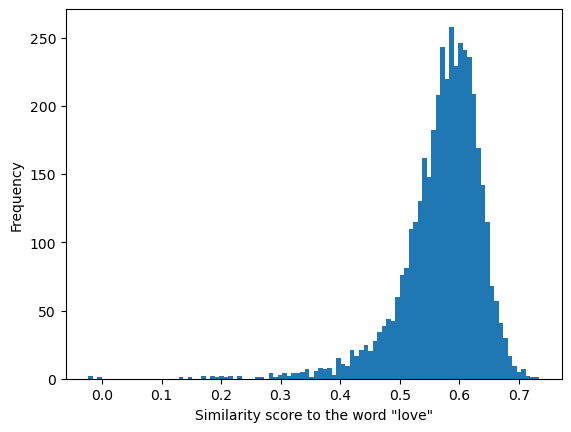

In [26]:
#plot the similarity score of the summaries to the reference word
plot_df_removed['love'].plot(kind='hist', bins=100)
plt.ylabel('Frequency')
plt.xlabel('Similarity score to the word "love"')
plt.show()


### 3. Love words extraction

In the previous part of the analysis, we have given similarity scores to each plot summary, which reflect how semantically close a summary is to the word "love". Now, we have to set a threshold to classify words as love-related or not. This presents a second challenge for this method. Picking the optimal threshold is not trivial. A threshold that is too low will result in many unrelated words, whereas a threshold that is too high will result in a low recall of romantic movies. We will show this effect here, by presenting the results of three thresholds. With a threshold of 0.9, only the word 'love' is classified as love-related. At a threshold of 0.6, we see more good words popping up, like 'feel' and 'like'. However, already at this threshold there are some questionable words, like 'think' and 'thought'. At a threshold of 0.3, there are too many words of which many unrelated to love. 

In [30]:
#The threshold is the minimum similarity score to be considered a love-related word
love_thresholds = [0.9, 0.6, 0.3]

for love_threshold in love_thresholds:
#Create a column with the love-related words in the summaries
    plot_df_removed['love_words'] = np.nan
    plot_df_removed['love_words'] = plot_df_removed['Summary'].apply(lambda x :extract_love_words(x, words=words, threshold=love_threshold)) 
    
    #sort love-related words by similarity to love
    for word in words:
        plot_df_removed['love_words'] = plot_df_removed['love_words'].apply(lambda x: sorted(x, key=lambda y: nlp_spacy(y).similarity(words)))

    #concatenate all the love-related words in a list
    love_words = []
    love_words = [love_words + word for word in plot_df_removed["love_words"]]
    love_words = np.unique(list(np.concatenate(love_words).flat))
    print('For threshold ', love_threshold, ', the following words were classified as love-related: \n', love_words)

For threshold  0.9 , the following words were classified as love-related: 
 ['love']
For threshold  0.6 , the following words were classified as love-related: 
 ['enjoy' 'feel' 'forget' 'fun' 'glad' 'great' 'hate' 'hope' 'joy' 'know'
 'like' 'love' 'miss' 'never' 'passion' 'sweet' 'thing' 'think' 'thought'
 'want' 'wish' 'wonder']
For threshold  0.3 , the following words were classified as love-related: 
 ['abandon' 'accent' 'accept' ... 'younger' 'youth' 'yu']


When the threshold goes down to 0.3, we see a large increase in the number of love-related words. This illustrates the importance of setting the threshold.

In [55]:
print('Threshold 0.3 gives', len(love_words), 'love-related words, of which the first 20 are: \n', love_words[:20])

Threshold 0.3 gives 1054 love-related words, of which the first 20 are: 
 ['abandon' 'accent' 'accept' 'act' 'add' 'addict' 'admit' 'adult' 'affair'
 'affection' 'afford' 'afraid' 'age' 'ago' 'ah' 'ai' 'album' 'almost'
 'along' 'alright']


Below, we see the top 5 movies, ranked by their similarity to the word "love". When opting for this approach, a further analysis can be done by considering metadata on the movie and characters through the wikipedia ID.

In [44]:
plot_df_removed.head(5)

,Wikipedia ID,Summary,love,love_words
8439,9843384,"[nicol, love, boyfriend, robbi, readi, start, ...",0.734472,"[start, move, end, new, brother, talk, relatio..."
9869,13115364,"[offici, websit, get, fall, love, inlaw, outla...",0.725997,"[film, straight, gay, heartbreak, care, meet, ..."
37437,25022765,"[easygo, ray, seem, catch, break, boss, demand...",0.717786,"[catch, break, stand, girlfriend, seem, live, ..."
761,23607760,"[peter, fun, love, person, younger, brother, r...",0.716588,"[die, youth, younger, without, person, fall, b..."
23448,24572033,"[singer, nora, left, husband, new, flame, larr...",0.711655,"[left, pair, year, affair, singer, meet, daugh..."


### 4. Visualizing the semantic proximity

Last, we visualize the semantic proximity of the words in two plots. Note that we use the love-related words obtained from the 0.3 threshold, as this plot is mostly for visualization purposes and the lower threshold gives a larger number of words. Therefore, the data is less sparse.

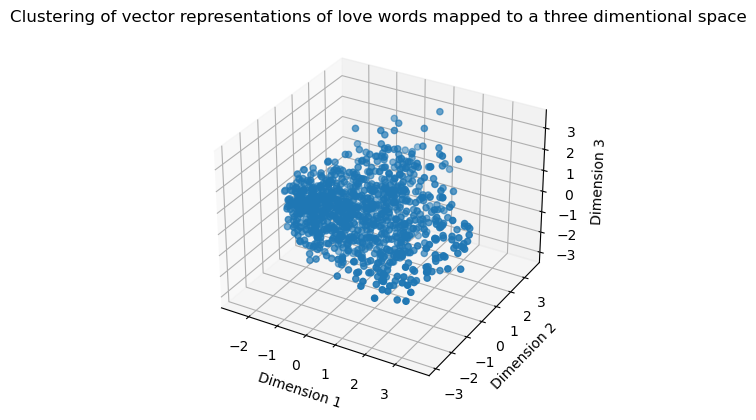

In [41]:
#Create a list of semantic vectors for each love-related word
love_words_vectors = [nlp_spacy(str(word)).vector for word in love_words]

#reduce the dimensionality of the word vectors to 3D
pca = PCA(n_components=3)
love_words_vectors_3D = pca.fit_transform(love_words_vectors)

#plot the 3D word vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(love_words_vectors_3D[:,0], love_words_vectors_3D[:,1], love_words_vectors_3D[:,2])

#Label axis as 'dimension 1', 'dimension 2' and 'dimension 3'
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

#Set title as 'Clustering of vector representations of love words mapped to a three dimentional space'
ax.set_title('Vector representations of love words mapped to a three dimentional space')
plt.show()


As a final visualization, we use k-means to cluster the love-related words. There may be several uses for this, as there may be several categories of love-related words. To illustrate, one categorie of love-related words could be emotions (happy, elated, enthusiastic), whereas another category could be pronouns (wedding, ring, hug). 

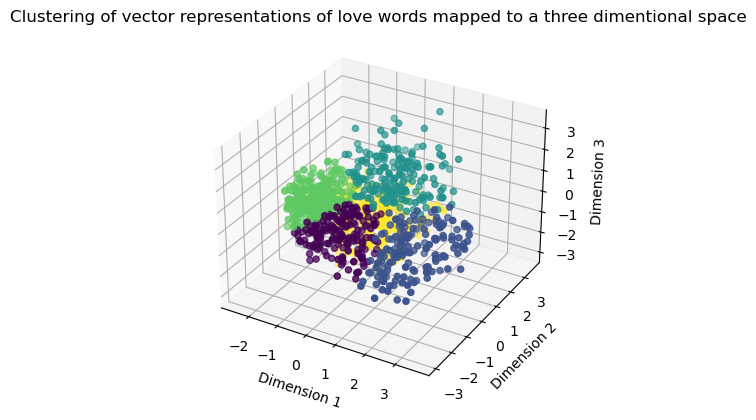

In [56]:
#cluster the word vectors with kmeans
kmeans = KMeans(n_clusters=5, algorithm = 'elkan', random_state=0).fit(love_words_vectors_3D)

#plot the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(love_words_vectors_3D[:,0], love_words_vectors_3D[:,1], love_words_vectors_3D[:,2], c=kmeans.labels_)

#Label axis as 'dimension 1', 'dimension 2' and 'dimension 3'
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

#Set title as 'Clustering of vector representations of love words mapped to a three dimentional space'
ax.set_title('Clustering of vector representations of love words mapped to a three dimentional space')
plt.show()


### 5. Next Steps

We have 2 main problems with this approach:
- How shall we define the reference vector ?
- How is the threshold set ?

#### 5.1. Reference vector

The reference vector for now is just the semantic vector of the word "love". We have to implement a methodology that allows us to find the best reference vector. We have to find a way to define the reference vector in a way that it scores high all the summaries that depicts a relationship. To do this we are thinking of a cross-validation approach and use the movies labeled as romantic by their genres as the target true positives.

#### 5.2. Threshold

Once we have a correct reference vector that scores the summaries as wanted, we need to find the best way to set the threshold splitting the movies that depicts a relation from the ones that don't. We are thinking of using an F1-scoring method to find it.